In [1]:
import json
import os
import itertools

import rootpath
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib
# matplotlib.use('Agg') # Must be before importing matplotlib.pyplot or pylab!
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import geopandas as gpd
import pycountry as pc
import pycountry_convert as pcc

from lhledge import cfgLoader
from lhledge import lhlFilters
from lhledge import loadGeographicData

In [2]:
CYCLE = 10020
DOWNSAMPLING = 1

In [3]:
def ecdf(data, w=[]):
    """ Compute ECDF """
    if len(w) == 0:
        w = np.ones(len(data))
    #
    #     x = np.sort(data)
    idx = np.argsort(data).values
    #
    x = np.array(data)
    x = x[idx]
    w = w[idx]
    #
    n = x.size
    #     y = np.arange(1, n + 1) / n
    y = np.cumsum(w) / sum(w)
    return (np.squeeze(x), y)

In [4]:
def ecdf2(df, field, field_aux):
    df = df.sort_values(field)
    y = np.cumsum(df.groupby(field)["router_id"].count().values)
    y = y / max(y)
    x = df.drop_duplicates(field)[field].values
    return x, y

In [5]:
# Change directory to run from the root dir of the project
path = rootpath.detect(pattern=".git")
os.chdir(path)

# load config file
cfg = cfgLoader.cfgLoader("config.yml")

In [6]:
df = pd.read_csv(f"data/processed/snapshots/{CYCLE}.csv.gz", compression="gzip")

In [7]:
cepii = loadGeographicData.load_inter_country_distances("data/external/cepii/dist_cepii.csv", 
                                                        "data/processed/min-cc-dist/min_cc_dist.csv")
cepii.head()

,cc_src,cc_dst,dist
0,AW,AW,5.225315
1,AW,AF,13257.810000
2,AW,AO,9516.913000
3,AW,AI,983.268200
4,AW,AL,9091.742000


In [8]:
G = nx.from_pandas_edgelist(
   df.loc[df["diff_rtt"] > 57].drop_duplicates(["near_node_id", "far_node_id",]),
    "near_node_id",
    "far_node_id",
    edge_attr='diff_rtt'
)

nx.set_node_attributes(
    G,
    pd.Series(
        df["near_side_cc"].values,
        index=df["near_node_id"]
    ).to_dict(),
    'cc',
)
nx.set_node_attributes(
    G,
    pd.Series(
        df["far_side_cc"].values,
        index=df["far_node_id"]
    ).to_dict(),
    'cc',
)

In [9]:
all_vals = []
cc_list = []
rtt_vals = []
for n1, n2, weight  in G.edges(data=True):
    cc1 = G.nodes()[n1]["cc"]
    cc2 = G.nodes()[n2]["cc"]
    cc_str_1 = f"{cc1}-{cc2}"
    cc_str_2 = f"{cc2}-{cc1}"
    if (cc_str_1 not in cc_list) and (cc_str_2 not in cc_list):
        cc_list.append(cc_str_1)
    rtt_vals.append(weight["diff_rtt"])
    all_vals.append((cc1, cc2, weight["diff_rtt"]))

In [10]:
l = []

for str_cc in cc_list:
    cc1, cc2 = str_cc.split("-")
    l.append((cc1, cc2))

cc_graph = pd.DataFrame(l, columns=["cc1", "cc2"])
cc_graph = cc_graph.join(
    cepii[["cc_src", "cc_dst", "dist"]].set_index(["cc_src", "cc_dst"]),
    on=["cc1", "cc2"],
    how='left',
    lsuffix='_left',
    rsuffix='_right'
)
cc_graph.head()


,cc1,cc2,dist
0,AE,CH,4407.826551
1,CH,JP,9214.366906
2,AE,DE,4266.720006
3,DE,US,5297.217204
4,AE,US,10133.024219


In [11]:
all_vals = pd.DataFrame(all_vals, columns=["cc1", "cc2", "diff_rtt"])
all_vals = all_vals.join(
    cepii[["cc_src", "cc_dst", "dist"]].set_index(["cc_src", "cc_dst"]),
    on=["cc1", "cc2"],
    how='left',
    lsuffix='_left',
    rsuffix='_right'
)
all_vals.head()

,cc1,cc2,diff_rtt,dist
0,AE,CH,114.876,4407.826551
1,CH,JP,209.294,9214.366906
2,CH,JP,211.329,9214.366906
3,AE,DE,67.622,4266.720006
4,DE,US,80.180,5297.217204


In [12]:
H = nx.from_pandas_edgelist(
   cc_graph,
    "cc1",
    "cc2",
)

print(f"nodes: {len(G.nodes())}")
print(f"edges: {len(G.edges())}")
print(f"countries: {len(H.nodes())}")



nodes: 31773
edges: 85620
countries: 170


In [13]:
G0 = nx.from_pandas_edgelist(
   df.drop_duplicates(["near_node_id", "far_node_id",]),
    "near_node_id",
    "far_node_id",
    edge_attr='diff_rtt'
)

In [14]:
G1 = nx.from_pandas_edgelist(
   df,
    "near_node_id",
    "far_node_id",
    edge_attr='diff_rtt'
)

In [15]:
len(G0.edges())

85620

In [16]:
len(G1.edges())

85620

In [17]:
G = nx.from_pandas_edgelist(
   df.drop_duplicates(["near_node_id", "far_node_id",]),
    "near_node_id",
    "far_node_id",
    edge_attr='diff_rtt'
)

nx.set_node_attributes(
    G,
    pd.Series(
        df["near_side_cc"].values,
        index=df["near_node_id"]
    ).to_dict(),
    'cc',
)
nx.set_node_attributes(
    G,
    pd.Series(
        df["far_side_cc"].values,
        index=df["far_node_id"]
    ).to_dict(),
    'cc',
)


In [18]:

hits = {}

for n1, n2, weight  in G.edges(data=True):
    cc1 = G.nodes()[n1]["cc"]
    cc2 = G.nodes()[n2]["cc"]

    cc1_3 = pc.countries.get(alpha_2=cc1).alpha_3
    cc2_3 = pc.countries.get(alpha_2=cc2).alpha_3

    if cc1_3 not in hits.keys():
        hits[cc1_3] = 0
    if cc2_3 not in hits.keys():
        hits[cc2_3] = 0

    hits[cc1_3] += 1
    hits[cc2_3] += 1

In [19]:
cc3_edges = pd.DataFrame(hits.items(), columns = ["iso_a3", "cnt"])
cc3_edges.head()

,iso_a3,cnt
0,ARE,141
1,CHE,1339
2,JPN,1497
3,DEU,30906
4,USA,68432


In [20]:
def get_continent(cc):
    if cc == "":
        return ""

    try:
        country = pc.countries.get(alpha_2=cc)
        continent = pcc.country_alpha2_to_continent_code(country.alpha_2)
        return continent
    except:
        return ""

In [21]:
segments = gpd.read_file(cfg["paths"]["segment-length"])
segments["from_continent"] = segments["from_country"].map(get_continent)
segments["to_continent"] = segments["to_country"].map(get_continent)

In [22]:
segments.head()

,cable_id,from_city,from_state,from_country,to_city,to_state,to_country,dist,cable_wkt,geometry,from_continent,to_continent
0,adria-1,Durrës,Durrës,AL,Dubrovnik,Dubrovacko-Neretvanska,HR,196.0955672734357,MULTILINESTRING ((19.4482079658 41.317799702,None,EU,EU
1,adria-1,Durrës,Durrës,AL,Kerkira,Ionioi Nisoi,GR,246.79221890016078,MULTILINESTRING ((19.4482079658 41.317799702,None,EU,EU
2,adria-1,Dubrovnik,Dubrovacko-Neretvanska,HR,Durrës,Durrës,AL,196.0955672734357,MULTILINESTRING ((18.0913915595 42.6609476919,None,EU,EU
3,adria-1,Dubrovnik,Dubrovacko-Neretvanska,HR,Kerkira,Ionioi Nisoi,GR,442.88778617359645,MULTILINESTRING ((18.0913915595 42.6609476919,None,EU,EU
4,adria-1,Kerkira,Ionioi Nisoi,GR,Durrës,Durrës,AL,246.7922189001608,MULTILINESTRING ((19.9147427965 39.615422993,None,EU,EU


In [23]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

130.80599999999998
7076.108023702327


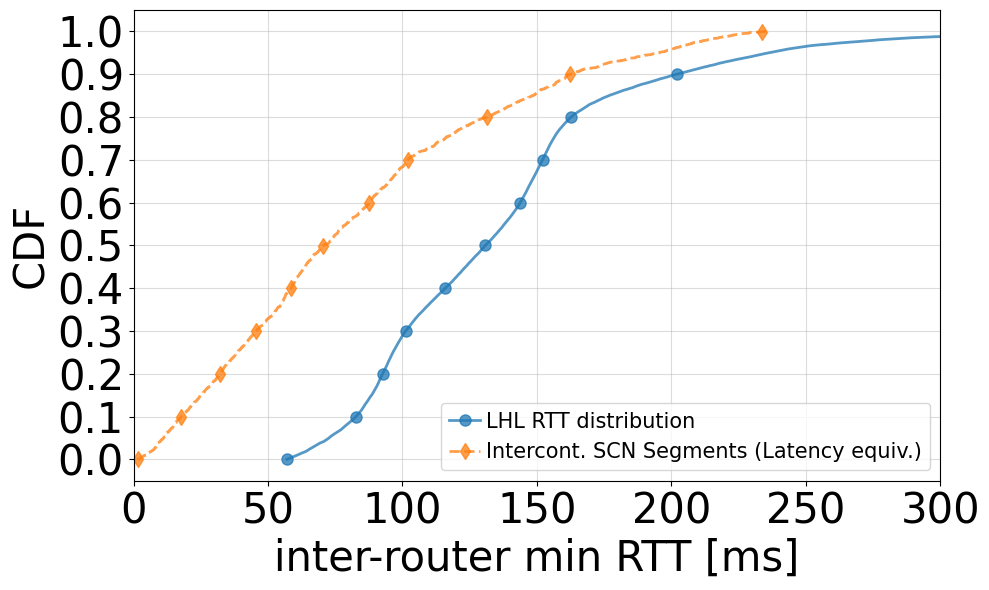

In [24]:
m = itertools.cycle(["o", "d", "^", "s"])

fig, ax = plt.subplots(1, figsize=(10, 6), sharey=True)

ax.yaxis.grid(True, linestyle='-', color='#bababa', alpha=0.5, which='both')
ax.xaxis.grid(True, linestyle='-', color='#bababa', alpha=0.5, which='both')


print(np.median(rtt_vals))
ax.plot(
    np.sort(rtt_vals),
    np.linspace(0, 1, len(rtt_vals)),
    marker=next(m),
    markevery = int(len(rtt_vals) / 10),
    markersize=8,
    lw=2,
    alpha=0.75,
    label="LHL RTT distribution"
)

x = np.sort(segments.loc[segments["from_continent"] != segments["to_continent"]]["dist"].values.astype(float))
print(np.median(x))
ax.plot(
    x / 100,
    np.linspace(0, 1, len(x)),
    marker=next(m),
    markevery = int(len(x) / 10),
    markersize=8,
    lw=2,
    alpha=0.75,
    ls="--",
    label="Intercont. SCN Segments (Latency equiv.)"
)



ax.set_yticks(np.arange(0, 1.01, 0.1))
ax.set_ylabel('CDF', fontsize=30)
ax.set_xlabel('inter-router min RTT [ms]', fontsize=30)
ax.tick_params(labelsize=30)
ax.set_xlim(0, 300)

ax.legend(loc='lower right', ncol=1, frameon=True, fontsize=15,
          handletextpad=0.25, columnspacing=0.1, handlelength=1.5)

fig.subplots_adjust(hspace=0)
fig.tight_layout()

# fig.savefig("figures/ulh-prevalence/router_level_rtt_dist_3.pdf")